Using N=30, L_section=1.167e-09 H, C_section=4.667e-13 F


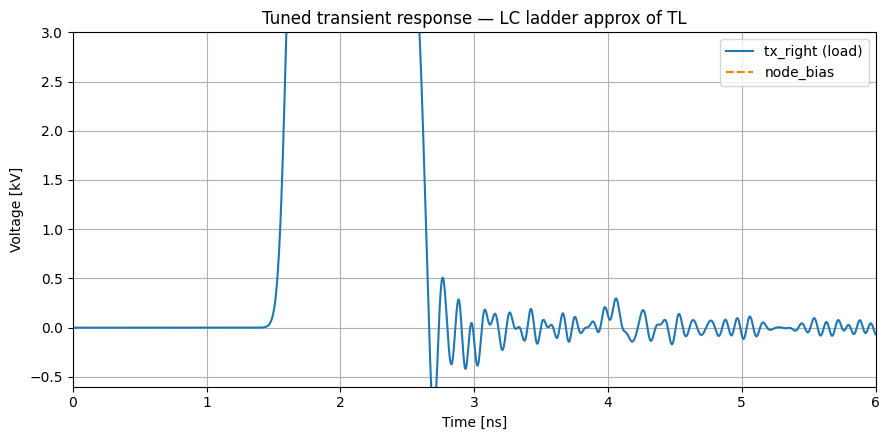

In [8]:
# Tuned PySpice + LC-ladder pulser for closer match to provided waveform
from PySpice.Spice.Netlist import Circuit
from PySpice.Unit import *
import matplotlib.pyplot as plt
import numpy as np

# ---------- Tuned parameters ----------
V_batt = 4500.0         # V (4.5 kV)
R_bias = 10.0           # ohm (was 1k -> lower to deliver more energy)
Z0 = 50.0               # characteristic impedance (ohm)
TD = 0.7e-9             # total delay (s)
N_sections = 30         # more sections -> better TL approximation
RON = 0.05              # switch ON resistance (ohm) - made small
ROFF = 1e9              # switch OFF resistance (ohm)
Vt_switch = 2.5         # switch threshold (V)
# small series resistor at switch-TL node to stabilise ringing shape
R_switch_series = 0.5   # ohm

# control pulse (timing tuned so plateau ~0.85ns to ~1.9ns)
pulse_str = 'PULSE(0 5 0.85n 0.01n 0.01n 1.05n 5n)'

# Derived per-section values for LC ladder
tau = TD / N_sections
C_section = tau / Z0
L_section = Z0 * tau

print(f'Using N={N_sections}, L_section={L_section:.3e} H, C_section={C_section:.3e} F')

# ---------- Build circuit ----------
circuit = Circuit('Tuned PCSS Pulser - LC ladder')

# Battery & bias resistor
circuit.V('batt', 'Vbatt', circuit.gnd, V_batt @ u_V)
circuit.R('bias', 'Vbatt', 'node_bias', R_bias @ u_Ohm)

# Control pulse (laser trigger)
circuit.V('ctrl', 'ctrl', circuit.gnd, pulse_str)

# Add 4-terminal V-controlled switch as raw spice (nc- tied to 0)
if isinstance(circuit.raw_spice, str):
    circuit.raw_spice += "S1 node_bias tx_left_ctrl ctrl 0 SWPCSS\n"
else:
    circuit.raw_spice.append("S1 node_bias tx_left_ctrl ctrl 0 SWPCSS")

# Switch model
circuit.model('SWPCSS', 'SW', RON=RON, ROFF=ROFF, Vt=Vt_switch)

# small series resistor after switch to TX left node (stability & shape)
circuit.R('sser', 'tx_left_ctrl', 'tx_left', R_switch_series @ u_Ohm)

# Build LC ladder nodes
nodes = ['tx_left']
for i in range(1, N_sections+1):
    nodes.append(f'node_{i}')
nodes[-1] = 'tx_right'

# Add ladder: series L between nodes[i-1] and nodes[i], shunt C at nodes[i] to gnd
for i in range(1, len(nodes)):
    Lname = f'Lsec{i}'
    Cname = f'Csec{i}'
    n_prev = nodes[i-1]
    n_curr = nodes[i]
    circuit.L(Lname, n_prev, n_curr, L_section @ u_H)
    circuit.C(Cname, n_curr, circuit.gnd, C_section @ u_F)

# Matched load
circuit.R('L', 'tx_right', circuit.gnd, Z0 @ u_Ohm)

# ---------- Simulate ----------
simulator = circuit.simulator(temperature=25, nominal_temperature=25)
analysis = simulator.transient(step_time=2@u_ps, end_time=6@u_ns)

# ---------- Extract and plot ----------
t = np.array(analysis.time) * 1e9               # ns
v_tx_right = np.array(analysis.nodes['tx_right']) / 1e3   # kV
v_node_bias = np.array(analysis.nodes['node_bias']) / 1e3

plt.figure(figsize=(9,4.5))
plt.plot(t, v_tx_right, label='tx_right (load)')
plt.plot(t, v_node_bias, '--', label='node_bias')
plt.xlim(0,6)
plt.ylim(-0.6,3.0)
plt.xlabel('Time [ns]')
plt.ylabel('Voltage [kV]')
plt.title('Tuned transient response — LC ladder approx of TL')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
